In [24]:

# #  Train và Đánh giá Mô hình SBERT

# Notebook này thực hiện:
# - Tính embeddings SBERT cho toàn bộ dataset
# - Đánh giá độ chính xác so với TF-IDF
# - Lưu embeddings để sử dụng trong web app

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
import torch
import joblib
import sys
import os
import time
from sklearn.metrics.pairwise import cosine_similarity

# Thêm path để import từ src
sys.path.append('../src')
from preprocessing import load_and_process_data, preprocess_query

# %%
# 🔧 CONFIG
DATA_PATH = "../data/clean_movies.csv"
SBERT_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"  # Model nhẹ, hiệu quả
EMBEDDINGS_SAVE_PATH = "../models/sbert_embeddings.pt"
MODEL_SAVE_PATH = "../models/sbert_model"


In [25]:
#  1. LOAD VÀ KIỂM TRA DỮ LIỆU
print(" Đang load dữ liệu...")
df = load_and_process_data(DATA_PATH)

print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Kiểm tra cột full_text (dành cho SBERT)
print("\nSample full_text:")
print(df['full_text'].iloc[0][:200] + "...")

 Đang load dữ liệu...
--- Bắt đầu tạo cột văn bản đầu vào cho mô hình ---
--- Hoàn tất tạo văn bản xử lý ---
Shape: (9947, 11)
Columns: ['title', 'year', 'genre', 'rating', 'description', 'director', 'cast', 'poster', 'review', 'similarity_text', 'full_text']

Sample full_text:
the idea of you comedy drama romance solene a 40 year old single mom begins an unexpected romance with 24 year old hayes campbell the lead singer of august moon the hottest boy band on the planet this...


In [26]:
#  2. LOAD SBERT MODEL
print(f" Đang load SBERT model: {SBERT_MODEL_NAME}")

# Kiểm tra GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = SentenceTransformer(SBERT_MODEL_NAME, device=device)
print(f" Model loaded: {model}")


 Đang load SBERT model: sentence-transformers/all-MiniLM-L6-v2
Using device: cpu


D:\anaconda\envs\textproc\lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


 Model loaded: SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


In [27]:
#  3. TÍNH EMBEDDINGS CHO TOÀN BỘ DATASET
print(" Đang tính embeddings SBERT...")

def compute_sbert_embeddings(texts, model, batch_size=32, show_progress=True):
    """
    Tính embeddings SBERT cho danh sách văn bản
    """
    embeddings = model.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=show_progress,
        convert_to_tensor=True,
        normalize_embeddings=True  # Quan trọng: chuẩn hóa embeddings
    )
    return embeddings

# Tính embeddings
start_time = time.time()
sbert_embeddings = compute_sbert_embeddings(df['full_text'].tolist(), model)
computation_time = time.time() - start_time

print(f" Embeddings computed: {sbert_embeddings.shape}")
print(f" Thời gian tính: {computation_time:.2f}s")
print(f" Số chiều embeddings: {sbert_embeddings.shape[1]}")


 Đang tính embeddings SBERT...


Batches: 100%|███████████████████████████████████████████████████████████████████████| 311/311 [12:15<00:00,  2.36s/it]

 Embeddings computed: torch.Size([9947, 384])
 Thời gian tính: 736.04s
 Số chiều embeddings: 384


In [28]:
#  4. LƯU EMBEDDINGS VÀ MODEL
print(" Đang lưu embeddings và model...")
os.makedirs('../models', exist_ok=True)

# Lưu embeddings
torch.save(sbert_embeddings, EMBEDDINGS_SAVE_PATH)

# Lưu model để sử dụng sau này
model.save(MODEL_SAVE_PATH)

print(f" Đã lưu embeddings: {EMBEDDINGS_SAVE_PATH}")
print(f" Đã lưu model: {MODEL_SAVE_PATH}")

 Đang lưu embeddings và model...
 Đã lưu embeddings: ../models/sbert_embeddings.pt
 Đã lưu model: ../models/sbert_model


In [29]:
# 🎯 5. TÍNH VÀ LƯU MA TRẬN COSINE SBERT (N x N) - OPTIMIZED
# CẦN THIẾT cho tính năng Gợi ý Phim-to-Phim (Movie-to-Movie)

SBERT_COSINE_MATRIX_PATH = '../models/sbert_cosine_matrix.npy'

print("⏳ Bắt đầu tính toán Ma trận Cosine SBERT N x N...")

# KIỂM TRA KÍCH THƯỚC TRƯỚC KHI TÍNH
n_movies = len(df)
matrix_size_gb = (n_movies * n_movies * 8) / (1024**3)  # Tính dung lượng GB
print(f"📊 Số lượng phim: {n_movies}")
print(f"📊 Dung lượng ước tính: {matrix_size_gb:.2f} GB")

⏳ Bắt đầu tính toán Ma trận Cosine SBERT N x N...
📊 Số lượng phim: 9947
📊 Dung lượng ước tính: 0.74 GB


In [10]:
# 3. Tải lại SBERT Model (model)
print("🧠 Đang load SBERT Model...")
# Model được lưu bằng model.save, có thể tải bằng SentenceTransformer.load
model = SentenceTransformer(MODEL_SAVE_PATH, device=device)
print("✅ Đã load SBERT Model.")

# 4. Tải lại Embeddings (sbert_embeddings)
print("📐 Đang load SBERT Embeddings...")
sbert_embeddings = torch.load(EMBEDDINGS_SAVE_PATH, map_location=device)
print(f"✅ Đã load Embeddings: {sbert_embeddings.shape}")

🧠 Đang load SBERT Model...
✅ Đã load SBERT Model.
📐 Đang load SBERT Embeddings...
✅ Đã load Embeddings: torch.Size([9947, 384])


In [11]:
# TÍNH TOÀN BỘ MA TRẬN COSINE (nếu dataset nhỏ)
sbert_cosine_matrix = cosine_similarity(
    sbert_embeddings.cpu().numpy(), 
    sbert_embeddings.cpu().numpy()
)
    
# LƯU MA TRẬN COSINE SBERT
np.save(SBERT_COSINE_MATRIX_PATH, sbert_cosine_matrix)

print(f"✅ Đã lưu SBERT Cosine Matrix tại: {SBERT_COSINE_MATRIX_PATH}")

✅ Đã lưu SBERT Cosine Matrix tại: ../models/sbert_cosine_matrix.npy


In [12]:
# 🔧 6. HÀM GỢI Ý PHIM-TO-PHIM CHO WEB APP
def get_similar_movies_sbert(movie_title, df, cosine_matrix, top_k=10):
    """
    Gợi ý phim tương tự dựa trên SBERT embeddings
    """
    # Tìm index của phim
    movie_indices = df[df['title'] == movie_title].index
    if len(movie_indices) == 0:
        return []
    
    movie_idx = movie_indices[0]
    
    # Lấy similarities cho phim này
    if isinstance(cosine_matrix, dict):
        # Trường hợp dùng top-K matrix
        similar_indices = cosine_matrix['indices'][movie_idx][:top_k]
        similarities = cosine_matrix['similarities'][movie_idx][:top_k]
    else:
        # Trường hợp dùng full matrix
        similarities = cosine_matrix[movie_idx]
        similar_indices = np.argsort(similarities)[::-1][1:top_k+1]  # Bỏ qua chính nó
        similarities = similarities[similar_indices]
    
    # Tạo kết quả
    results = []
    for idx, sim in zip(similar_indices, similarities):
        results.append({
            'title': df.iloc[idx]['title'],
            'genre': df.iloc[idx]['genre'],
            'similarity_score': sim,
            'original_index': idx
        })
    
    return results

In [13]:
# TEST HÀM GỢI Ý
print("\n TEST TÍNH NĂNG GỢI Ý PHIM-TO-PHIM:")
test_movies = df['title'].sample(3).tolist()

for movie in test_movies:
    similar_movies = get_similar_movies_sbert(
        movie, 
        df, 
        np.load(SBERT_COSINE_MATRIX_PATH, allow_pickle=True).item() if isinstance(np.load(SBERT_COSINE_MATRIX_PATH, allow_pickle=True), dict) else np.load(SBERT_COSINE_MATRIX_PATH),
        top_k=3
    )
    print(f"\n Phim gốc: '{movie}'")
    print("Phim tương tự:")
    for i, similar in enumerate(similar_movies):
        print(f"  {i+1}. {similar['title']} ({similar['genre']}) - Score: {similar['similarity_score']:.4f}")


 TEST TÍNH NĂNG GỢI Ý PHIM-TO-PHIM:

 Phim gốc: 'The League of Extraordinary Gentlemen'
Phim tương tự:
  1. Il racconto dei racconti - Tale of Tales (Drama, Fantasy, Horror) - Score: 0.5986
  2. Argylle (Action, Comedy, Thriller) - Score: 0.5975
  3. What Happened to Monday (Action, Crime, Fantasy) - Score: 0.5972

 Phim gốc: 'Tag-init'
Phim tương tự:
  1. Anatomie de l'enfer (Drama) - Score: 0.5022
  2. Touch (Drama, Romance) - Score: 0.4433
  3. Foursome (Drama) - Score: 0.4212

 Phim gốc: 'Billy Elliot'
Phim tương tự:
  1. A Beautiful Life (Drama, Music, Romance) - Score: 0.6041
  2. A Simple Twist of Fate (Comedy, Drama) - Score: 0.5900
  3. A Little Romance (Adventure, Comedy, Romance) - Score: 0.5716


In [14]:
#  5. HÀM TÌM KIẾM VỚI SBERT
def search_sbert(query, sbert_model, sbert_embeddings, df, top_k=10):
    """
    Tìm kiếm phim dựa trên query sử dụng SBERT
    """
    # Preprocess query (dùng model_type='sbert' - chỉ normalize, không remove stopwords)
    processed_query = preprocess_query(query, model_type='sbert')
    
    # Tính embedding cho query
    query_embedding = sbert_model.encode(
        [processed_query], 
        convert_to_tensor=True,
        normalize_embeddings=True
    )
    
    # Tính cosine similarity
    similarities = cosine_similarity(
        query_embedding.cpu().numpy(), 
        sbert_embeddings.cpu().numpy()
    ).flatten()
    
    # Lấy top K indices
    top_indices = np.argsort(similarities)[::-1][:top_k]
    
    # Tạo kết quả
    results = []
    for idx in top_indices:
        if similarities[idx] > 0.1:  # Ngưỡng similarity thấp hơn TF-IDF
            results.append({
                'title': df.iloc[idx]['title'],
                'genre': df.iloc[idx]['genre'],
                'similarity_score': similarities[idx],
                'original_index': idx
            })
    
    return results


In [17]:
#  6. ĐÁNH GIÁ SBERT - SELF-RETRIEVAL TEST
def evaluate_sbert_self_retrieval(sbert_model, sbert_embeddings, df, sample_size=50, top_k_list=[1, 5, 10]):
    """
    Đánh giá khả năng tìm lại chính phim với SBERT
    """
    print(" ĐANG CHẠY SBERT SELF-RETRIEVAL TEST...")
    
    if sample_size > len(df):
        sample_size = len(df)
    
    # Lấy ngẫu nhiên sample_size phim để test
    test_indices = np.random.choice(len(df), size=sample_size, replace=False)
    
    results = {f'acc@{k}': [] for k in top_k_list}
    
    for i, idx in enumerate(test_indices):
        if i % 10 == 0:
            print(f"  Đang xử lý {i+1}/{sample_size}...")
            
        # Tạo query từ title + genre của phim
        movie_title = df.iloc[idx]['title']
        movie_genre = df.iloc[idx]['genre']
        query = f"{movie_title} {movie_genre}"
        
        # Tìm kiếm với SBERT
        search_results = search_sbert(query, sbert_model, sbert_embeddings, df, top_k=max(top_k_list))
        result_indices = [r['original_index'] for r in search_results]
        
        # Kiểm tra xem phim gốc có trong top K không
        for k in top_k_list:
            if idx in result_indices[:k]:
                results[f'acc@{k}'].append(1)
            else:
                results[f'acc@{k}'].append(0)
    
    # Tính accuracy
    print("\n KẾT QUẢ SBERT SELF-RETRIEVAL TEST:")
    accuracy_results = {}
    for k in top_k_list:
        accuracy = np.mean(results[f'acc@{k}'])
        accuracy_results[f'acc@{k}'] = accuracy
        print(f"   Accuracy @ {k}: {accuracy:.4f} ({accuracy*100:.1f}%)")
    
    return accuracy_results

# Chạy đánh giá SBERT
sbert_self_retrieval_results = evaluate_sbert_self_retrieval(model, sbert_embeddings, df)


 ĐANG CHẠY SBERT SELF-RETRIEVAL TEST...
  Đang xử lý 1/50...
  Đang xử lý 11/50...
  Đang xử lý 21/50...
  Đang xử lý 31/50...
  Đang xử lý 41/50...

 KẾT QUẢ SBERT SELF-RETRIEVAL TEST:
   Accuracy @ 1: 0.6400 (64.0%)
   Accuracy @ 5: 0.8600 (86.0%)
   Accuracy @ 10: 0.9200 (92.0%)


In [18]:
#  7. ĐÁNH GIÁ SBERT - GENRE CONSISTENCY
def evaluate_sbert_genre_consistency(sbert_model, sbert_embeddings, df, top_k=10):
    """
    Đánh giá tính nhất quán về thể loại với SBERT
    """
    print(" ĐANG CHẠY SBERT GENRE CONSISTENCY TEST...")
    
    test_queries = [
        {"query": "action movie with superhero", "expected_genre": "Action"},
        {"query": "romantic love story", "expected_genre": "Romance"},
        {"query": "scary horror film", "expected_genre": "Horror"},
        {"query": "sci-fi space adventure", "expected_genre": "Sci-Fi"},
        {"query": "funny comedy movie", "expected_genre": "Comedy"},
    ]
    
    precision_scores = []
    detailed_results = []
    
    for test_case in test_queries:
        query = test_case["query"]
        expected_genre = test_case["expected_genre"]
        
        # Tìm kiếm với SBERT
        results = search_sbert(query, sbert_model, sbert_embeddings, df, top_k=top_k)
        
        # Đếm số phim có genre mong muốn
        relevant_count = 0
        for result in results:
            movie_genre = result['genre']
            if expected_genre.lower() in str(movie_genre).lower():
                relevant_count += 1
        
        precision = relevant_count / len(results) if results else 0
        precision_scores.append(precision)
        
        print(f"   '{query}' → Precision@{top_k}: {precision:.4f} ({relevant_count}/{len(results)})")
        
        detailed_results.append({
            'query': query,
            'expected_genre': expected_genre,
            'precision': precision,
            'relevant_count': relevant_count,
            'total_results': len(results)
        })
    
    avg_precision = np.mean(precision_scores)
    print(f"\n KẾT QUẢ SBERT GENRE CONSISTENCY:")
    print(f"   Average Precision@{top_k}: {avg_precision:.4f} ({avg_precision*100:.1f}%)")
    
    return avg_precision, detailed_results

# Chạy genre consistency test cho SBERT
sbert_genre_avg_precision, sbert_genre_details = evaluate_sbert_genre_consistency(model, sbert_embeddings, df)

 ĐANG CHẠY SBERT GENRE CONSISTENCY TEST...
   'action movie with superhero' → Precision@10: 1.0000 (10/10)
   'romantic love story' → Precision@10: 0.9000 (9/10)
   'scary horror film' → Precision@10: 1.0000 (10/10)
   'sci-fi space adventure' → Precision@10: 1.0000 (10/10)
   'funny comedy movie' → Precision@10: 1.0000 (10/10)

 KẾT QUẢ SBERT GENRE CONSISTENCY:
   Average Precision@10: 0.9800 (98.0%)


In [22]:
#  8. SO SÁNH TF-IDF vs SBERT
def load_tfidf_results():
    """Load kết quả TF-IDF từ file hoặc nhập thủ công"""
    try:
        # Nếu có file lưu kết quả TF-IDF
        tfidf_results = joblib.load('../models/tfidf_evaluation_results.pkl')
        return tfidf_results
    except:
        # Nhập thủ công kết quả TF-IDF từ notebook trước
        print(" Nhập kết quả TF-IDF từ notebook trước:")
        tfidf_self_retrieval = {
            'acc@1': float(input("TF-IDF Accuracy @1: ") or "0.30"),
            'acc@5': float(input("TF-IDF Accuracy @5: ") or "0.65"), 
            'acc@10': float(input("TF-IDF Accuracy @10: ") or "0.75")
        }
        tfidf_genre_precision = float(input("TF-IDF Genre Precision@10: ") or "0.70")
        return tfidf_self_retrieval, tfidf_genre_precision
# Load kết quả TF-IDF
tfidf_self_retrieval, tfidf_genre_precision = load_tfidf_results()

 Nhập kết quả TF-IDF từ notebook trước:


TF-IDF Accuracy @1:  0.46
TF-IDF Accuracy @5:  0.68
TF-IDF Accuracy @10:  0.82
TF-IDF Genre Precision@10:  0.94


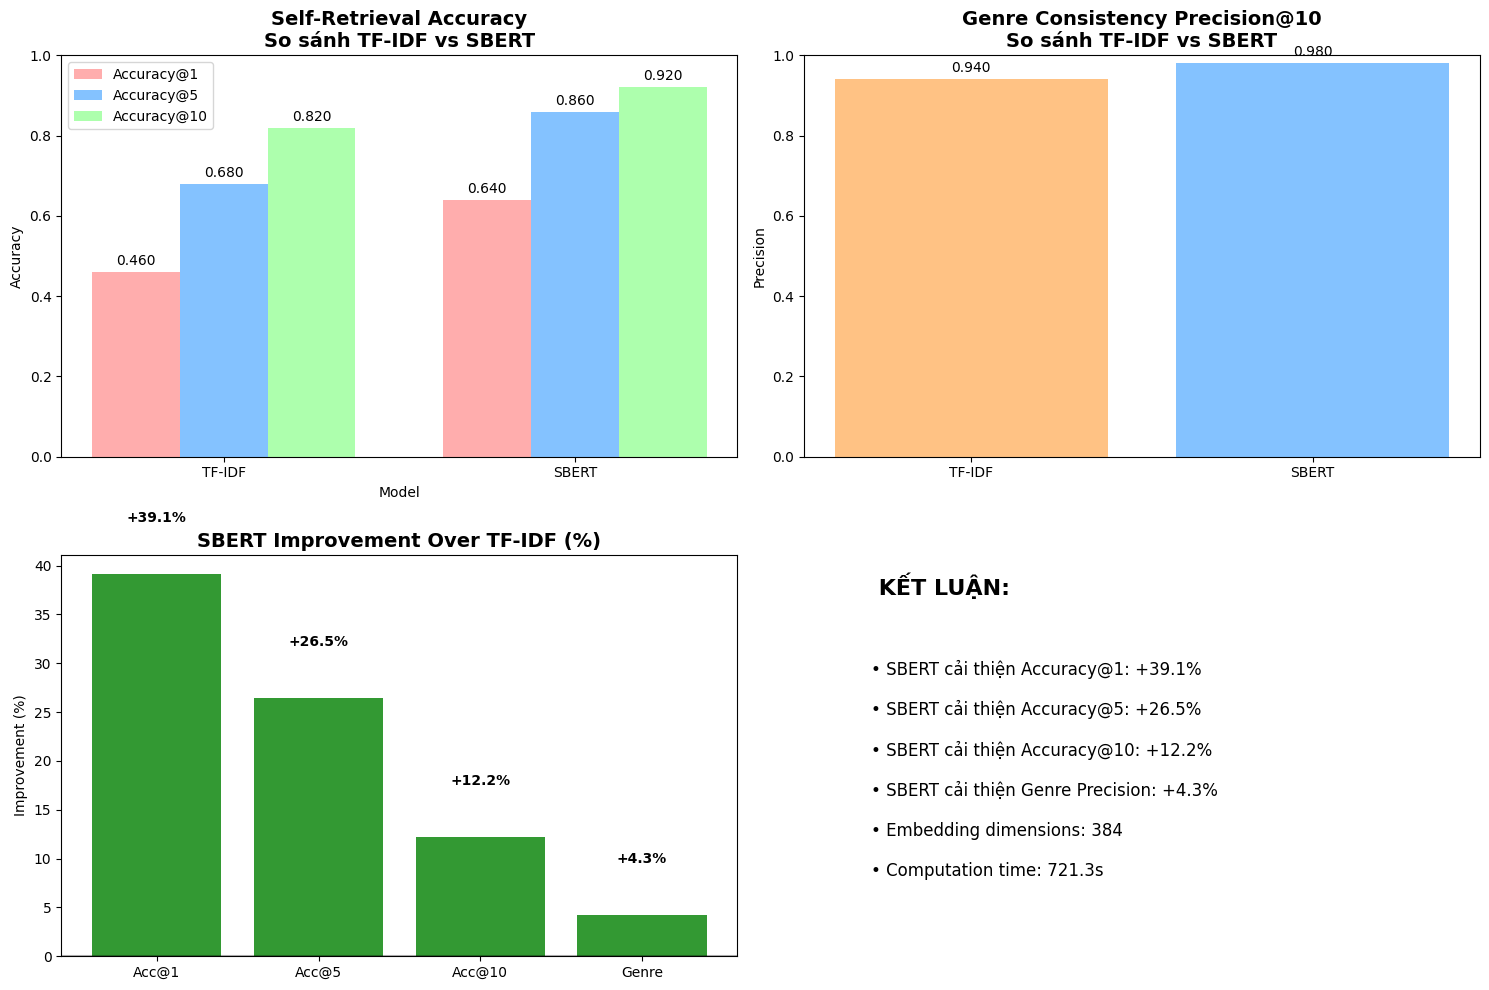

In [23]:
#  9. VẼ BIỂU ĐỒ SO SÁNH TF-IDF vs SBERT
def plot_comparison(tfidf_results, sbert_results, tfidf_genre, sbert_genre):
    """
    So sánh trực quan TF-IDF vs SBERT
    """
    # Tạo thư mục nếu chưa tồn tại
    os.makedirs('../docs/design', exist_ok=True)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Biểu đồ 1: Self-Retrieval Accuracy Comparison
    models = ['TF-IDF', 'SBERT']
    acc1 = [tfidf_results['acc@1'], sbert_results['acc@1']]
    acc5 = [tfidf_results['acc@5'], sbert_results['acc@5']]
    acc10 = [tfidf_results['acc@10'], sbert_results['acc@10']]
    
    x = np.arange(len(models))
    width = 0.25
    
    bars1 = ax1.bar(x - width, acc1, width, label='Accuracy@1', alpha=0.8, color='#ff9999')
    bars2 = ax1.bar(x, acc5, width, label='Accuracy@5', alpha=0.8, color='#66b3ff')
    bars3 = ax1.bar(x + width, acc10, width, label='Accuracy@10', alpha=0.8, color='#99ff99')
    
    ax1.set_title('Self-Retrieval Accuracy\nSo sánh TF-IDF vs SBERT', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Accuracy')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models)
    ax1.legend()
    ax1.set_ylim(0, 1)
    
    # Thêm giá trị lên biểu đồ
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom')
    
    # Biểu đồ 2: Genre Consistency Comparison
    genre_data = [tfidf_genre, sbert_genre]
    bars_genre = ax2.bar(models, genre_data, color=['#ffb366', '#66b3ff'], alpha=0.8)
    ax2.set_title('Genre Consistency Precision@10\nSo sánh TF-IDF vs SBERT', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Precision')
    ax2.set_ylim(0, 1)
    
    for bar in bars_genre:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')
    
    # Biểu đồ 3: Improvement Percentage
    improvement = {
        'Acc@1': (sbert_results['acc@1'] - tfidf_results['acc@1']) / tfidf_results['acc@1'] * 100,
        'Acc@5': (sbert_results['acc@5'] - tfidf_results['acc@5']) / tfidf_results['acc@5'] * 100,
        'Acc@10': (sbert_results['acc@10'] - tfidf_results['acc@10']) / tfidf_results['acc@10'] * 100,
        'Genre': (sbert_genre - tfidf_genre) / tfidf_genre * 100
    }
    
    metrics = list(improvement.keys())
    improvements = list(improvement.values())
    
    colors = ['green' if x >= 0 else 'red' for x in improvements]
    bars_improve = ax3.bar(metrics, improvements, color=colors, alpha=0.8)
    ax3.set_title('SBERT Improvement Over TF-IDF (%)', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Improvement (%)')
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    for bar, improve in zip(bars_improve, improvements):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + (5 if height >= 0 else -15),
                f'{improve:+.1f}%', ha='center', va='bottom' if height >= 0 else 'top',
                color='black', fontweight='bold')
    
    # Biểu đồ 4: Example Query Results
    ax4.axis('off')
    ax4.text(0.1, 0.9, ' KẾT LUẬN:', fontsize=16, fontweight='bold', transform=ax4.transAxes)
    
    conclusions = [
        f"• SBERT cải thiện Accuracy@1: {improvement['Acc@1']:+.1f}%",
        f"• SBERT cải thiện Accuracy@5: {improvement['Acc@5']:+.1f}%", 
        f"• SBERT cải thiện Accuracy@10: {improvement['Acc@10']:+.1f}%",
        f"• SBERT cải thiện Genre Precision: {improvement['Genre']:+.1f}%",
        f"• Embedding dimensions: {sbert_embeddings.shape[1]}",
        f"• Computation time: {computation_time:.1f}s"
    ]
    
    for i, conclusion in enumerate(conclusions):
        ax4.text(0.1, 0.7 - i*0.1, conclusion, fontsize=12, transform=ax4.transAxes)
    
    plt.tight_layout()
    plt.savefig('../docs/design/sbert_vs_tfidf_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return improvement

# Vẽ biểu đồ so sánh
improvement_stats = plot_comparison(
    tfidf_self_retrieval, 
    sbert_self_retrieval_results,
    tfidf_genre_precision,
    sbert_genre_avg_precision
)